In [18]:
#import libraries 
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.stats.distributions import chi2

#improt Data
csv = '/Users/samuelclark/Documents/UMBC Data Science /Introduction to Data Science/Final Project/Data/merged.csv'
df = pd.read_csv(csv, low_memory=False)
df.columns

Index(['Hour', 'Day', 'Month', 'CrashCount', 'Precipitation_indicator',
       'WEEKDAY', 'MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23', 'JAN', 'FEB', 'MAR', 'APR', 'MAY',
       'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'T_12to5AM',
       'T_6to11AM', 'T_12to5PM', 'T_6to11PM'],
      dtype='object')

In [19]:
#test, train, split
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=6902
Testing data set length=1854


In [20]:
#regerssion formula 

expr1 = """CrashCount ~  T_12to5AM + T_6to11AM + T_12to5PM + T_6to11PM + 
                        Precipitation_indicator + 
                        MO + TU + WE + TH + FR + SA + SU + 
                        JAN + FEB + MAR + APR + MAY + JUN + JUL + AUG + SEP + OCT + NOV + DEC """  

expr = """CrashCount ~  Hour_0 + Hour_1 + Hour_2 + Hour_3 + Hour_4 + Hour_5 + Hour_6 + Hour_7 + Hour_8 + Hour_9 + Hour_10 + Hour_11 + Hour_12 + Hour_13 + Hour_14 + Hour_15 + Hour_16 + Hour_17 + Hour_18 + Hour_19 + Hour_20 + Hour_21 + Hour_22 + Hour_23 +    
                        Precipitation_indicator + 
                        MO + TU + WE + TH + FR + SA + SU + 
                        JAN + FEB + MAR + APR + MAY + JUN + JUL + AUG + SEP + OCT + NOV + DEC"""  
            

In [21]:
#set up matricies
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [22]:
#poission
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             CrashCount   No. Observations:                 6902
Model:                            GLM   Df Residuals:                     6860
Model Family:                 Poisson   Df Model:                           41
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18997.
Date:                Sun, 09 May 2021   Deviance:                       8941.3
Time:                        20:51:48   Pearson chi2:                 8.91e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [23]:
#Compute estimated over dispersion.
#There is over dispersion so we can not use the poission regression
ratio = poisson_training_results.pearson_chi2/poisson_training_results.df_resid
ratio2 = poisson_training_results.deviance/poisson_training_results.df_resid
print('Chi-squared to degrees of freedom ratio is',ratio)
print('Deviance to degrees of freedom ratio is',ratio2)

Chi-squared to degrees of freedom ratio is 1.29899164594999
Deviance to degrees of freedom ratio is 1.3033975778912132


In [24]:
#Getting test results from the test data
poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
3     21.480249  0.461911      20.593733      22.404927
5     15.277171  0.322176      14.658589      15.921856
7     15.296741  0.318644      14.684787      15.934196
12    13.743671  0.291006      13.184983      14.326032
15    22.669144  0.497798      21.714175      23.666111
...         ...       ...            ...            ...
8719  18.038035  0.359935      17.346192      18.757472
8729  16.044316  0.328544      15.413133      16.701348
8747  23.204383  0.518133      22.210763      24.242454
8749  12.734089  0.267327      12.220771      13.268969
8754  16.460646  0.327993      15.830183      17.116218

[1854 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

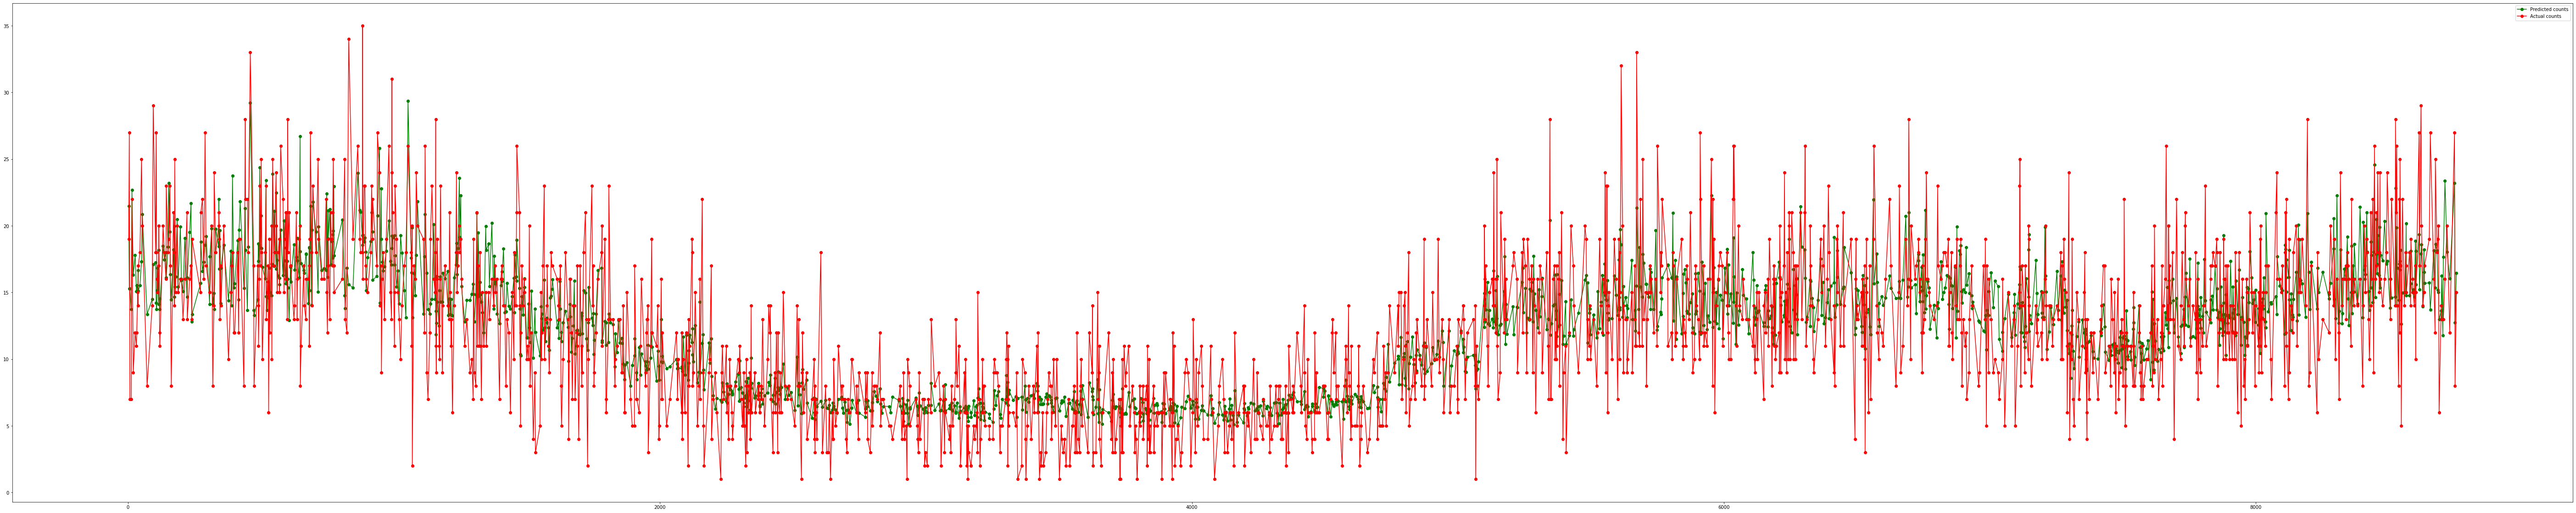

<Figure size 432x288 with 0 Axes>

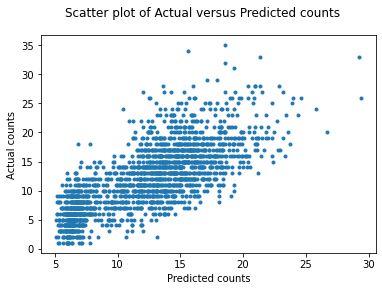

In [25]:
#Plotting actual and predicted results against the index of the data
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['CrashCount']
fig = plt.figure()
plt.figure(figsize=(100, 20))
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#scatterplot of actual vs predicted

plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [33]:
#negative binomial regression
NB_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha =.05)).fit()
print(NB_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             CrashCount   No. Observations:                 6902
Model:                            GLM   Df Residuals:                     6860
Model Family:        NegativeBinomial   Df Model:                           41
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18997.
Date:                Mon, 10 May 2021   Deviance:                       5758.9
Time:                        16:29:46   Pearson chi2:                 5.70e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [27]:
#Compute estimated over dispersion.
#There is over dispersion so we can not use the poission regression
ratio = NB_training_results.pearson_chi2/NB_training_results.df_resid
ratio2 = NB_training_results.deviance/NB_training_results.df_resid
print('Chi-squared to degrees of freedom ratio is',ratio)
print('Deviance to degrees of freedom ratio is',ratio2)

Chi-squared to degrees of freedom ratio is 0.8302460657041321
Deviance to degrees of freedom ratio is 0.8394836733176718


In [28]:
#prediction on the X training set. Mean is predicted values of the train set
NB_prediction = NB_training_results.get_prediction(X_test)
NB_predicted_summary_frame = NB_prediction.summary_frame()
print(NB_predicted_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
3     21.741410  0.623466      20.553145      22.998373
5     15.269069  0.427978      14.452871      16.131359
7     15.376771  0.423601      14.568545      16.229836
12    13.768959  0.382972      13.038440      14.540407
15    23.000328  0.674275      21.716023      24.360587
...         ...       ...            ...            ...
8719  18.105664  0.481864      17.185436      19.075167
8729  15.977024  0.434664      15.147414      16.852071
8747  23.547936  0.702301      22.210909      24.965446
8749  12.673441  0.349619      12.006396      13.377547
8754  16.441553  0.436473      15.607956      17.319671

[1854 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

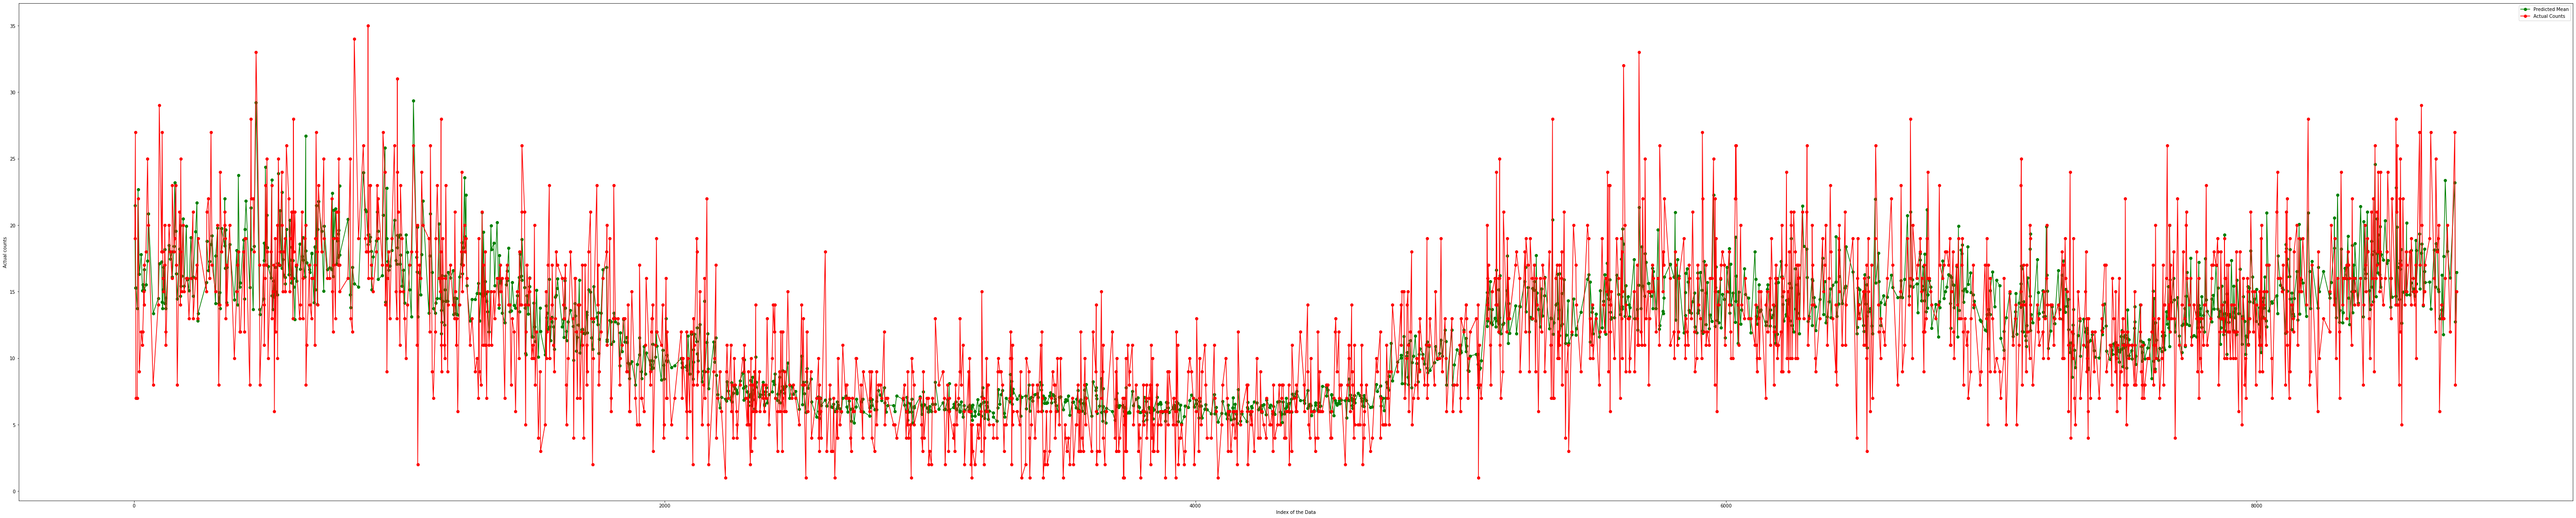

<Figure size 432x288 with 0 Axes>

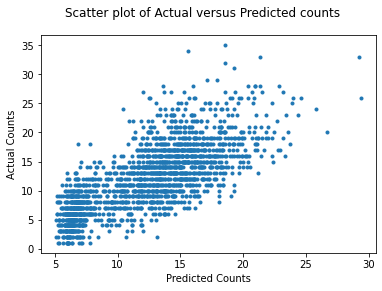

In [29]:
#plot of actual and predicted values against an index
actual_counts = y_test['CrashCount']
fig = plt.figure()
plt.figure(figsize=(100, 20))
fig.suptitle('Predicted versus actual car crash counts')
plt.xlabel('Index of the Data')
plt.ylabel('Actual counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted Mean')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual Counts')
plt.legend(handles=[predicted, actual])
plt.show()


#scatter of actual v prediced
NB_predicted_summary_frame=predictions_summary_frame['mean']
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=NB_predicted_summary_frame, y=actual_counts, marker='.')
plt.xlabel('Predicted Counts')
plt.ylabel('Actual Counts')
plt.show()

In [30]:
#root mean squared error 
y_actual = y_test
y_predicted = predictions_summary_frame['mean']

rmse = mean_squared_error(y_actual, y_predicted, squared=False)
print("The root mean squared error is",rmse)
print('The max value of the data is',y_predicted.max())
print('The min value of the data is',y_predicted.min())

The root mean squared error is 3.853974207052479
The max value of the data is 29.358697111816422
The min value of the data is 5.097737803385211


In [31]:
#comparing poission and negative binomial models by the liklihood ratio test

L1 = poisson_training_results.llf
L2 = NB_training_results.llf


def likelihood_ratio(llmin, llmax):
    return(2*(llmax-llmin))


LR = likelihood_ratio(L1,L2)
print(LR)


p = chi2.sf(LR, 22) # L2 has 1 DoF more than L1

print(p)




-0.777581355177972
1.0


In [35]:
#raw residuals
y_actual = y_testf
y_predicted=predictions_summary_frame['mean']
rr = (y_actual - y_predicted)
rr

,CrashCount,3,5,7,12,15,20,27,32,33,...,8697,8699,8703,8705,8711,8719,8729,8747,8749,8754
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#cross valdiation
